In [1]:
# подключим видеокарту
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e856217a-9177-482e-88b5-b78234309bbd)


In [2]:
# подготавливаем данные

!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'


#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
  ]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
- [1 files][  1.6 GiB/  1.6 GiB]   39.6 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


In [4]:
# импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import itertools
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import Xception # #ResNet50V2, ResNet50,InceptionV3, EfficientNetB5
from tensorflow.keras.layers import *

!pip install -U albumentations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor # Additional installations for Augmentor

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.6 MB 35 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-5nq6o99m
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-5nq6o99m
     |████████████████████████████████| 60.3 MB 36 kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29576 sha256=eb7af21ad866664779b841221e590ee9b3f9c239638b6e8aadd7703820b1e0bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9jk8r6q/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling o

In [5]:
# тут ключевые настройки. EPOCHS, BATCH, LR, IMG_SIZE будем определять на шагах тюнинга
CLASS_NUM            = 10  # количество классов в нашей задаче
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%
RANDOM_SEED          = 0

In [6]:

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 0.001
IMG_SIZE             = (240, 240) 
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (120, 120, IMG_CHANNELS) # какого размера подаем изображения в сеть

import albumentations as a

My_augments = a.Compose([
   # добавляем размытие по Гауссу и шум с вероятностью 5%
    a.GlassBlur(p=0.05), # add Gauss bluring and noise with 5% probability
    a.GaussNoise(p=0.05),
   
    a.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75), 
    a.RandomBrightness(limit=0.2, p=0.5),
    
#     Add some more aumentations with default parameters
    
    a.HorizontalFlip(), # as we take a look on car's model it may vary with different mirroring,
                        # then to get better result we can turn it on NO VERTICAL FLIP because cars are always in horizontal
    a.HueSaturationValue(), # random hue and saturation
    #a.RGBShift(),
    a.FancyPCA(alpha=0.1, always_apply=False,  p=0.5),
       
    #  add OneOfs with default 50% probability for brightness contrast
    a.OneOf([
        a.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        a.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5)
])

from ImageDataAugmentor import *

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = My_augments,
        validation_split=VAL_SPLIT,
        )
        
val_datagen = ImageDataAugmentor(rescale=1./255, validation_split=VAL_SPLIT,)

sub_datagen = ImageDataGenerator(rescale=1./255)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [7]:
# Генерация данных

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [8]:
# функция вывода изображений

def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.float)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()


Train:


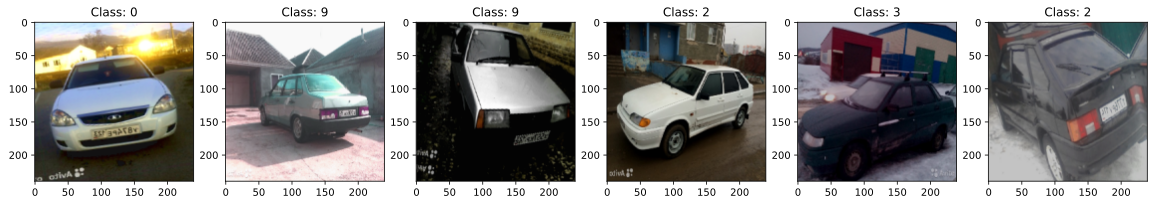

Val:


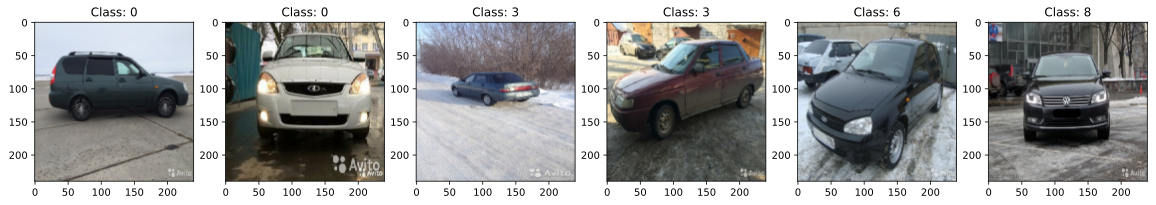

Sub:


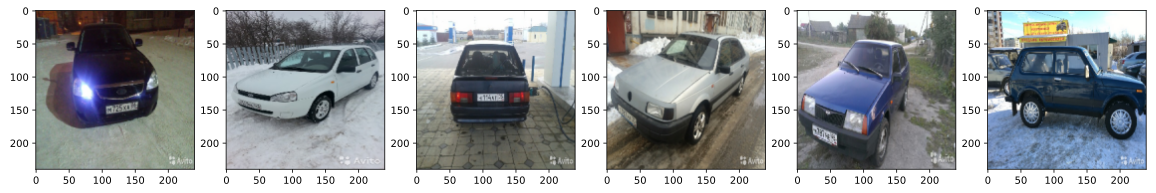

In [ ]:
print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [9]:
# функция вывода графиков обучения
def show_learn_graf(history):
      acc = history.history['accuracy']
      val_acc = history.history['val_accuracy']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      
      epochs = range(len(acc))

      fig, axes = plt.subplots(1, 2, figsize=(18,6))

      axes[0].plot(epochs, acc, 'b', label='Training acc')
      axes[0].plot(epochs, val_acc, 'r', label='Validation acc')
      axes[0].set_title('Training and validation accuracy')
      axes[0].legend()
      
      plt.figure()

      axes[1].plot(epochs, loss, 'b', label='Training loss')
      axes[1].plot(epochs, val_loss, 'r', label='Validation loss')
      axes[1].set_title('Training and validation loss')
      axes[1].legend()
      
      plt.show()

In [10]:
# формируем базовую модель

# эскперементировал с базовыми моделями. Лучший результат получал на Xception. Детальных логов не вел, так как с изменением модели
# менял и другие параметры - изменял настройки аугментации, менял размер LR, количество эпох. В целом свои ущущения по применению моделей описал ниже 

base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape) # голова давала самые лучшие результаты
#base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape = input_shape) # тут на голове начинало с 10% и поднималось медленно, дальше тестить не стал
#base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape = input_shape) # на 2-3 шаге разрыв accuracy между train & val был 10%
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_shape) # улучшения на голове по сравнению с Xception не было

base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 59, 59, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 59, 59, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [11]:
# устанавливаем новую голову

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(),)
model.add(BatchNormalization())  # после добавления Batch точность на голове стала лучше более чем на 10%

#x = Dropout(0.25)(x)

model.add(Dense(CLASS_NUM, activation='softmax'))

In [12]:
# тут начтинаем играть с fine-tuning
base_model.trainable = False 

In [13]:
# проверчем, что заморозили слои base_model
print("всего слоев:", len(model.layers))
print("обучаемых слоев:", len(model.trainable_variables))

всего слоев: 4
обучаемых слоев: 4


In [14]:
# собираем модель

model.compile(loss="categorical_crossentropy", 
                optimizer=optimizers.Adamax(learning_rate=LR), 
                metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20,890,162
Trainable params: 24,586
Non-trainable params: 20,865,576
_________________________________________________________________


In [15]:
# добавим чек-поинты
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [16]:
# тут обучаем только голову
%%time
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator, 
        validation_steps = len(val_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 1.7251 - accuracy: 0.4088
Epoch 00001: val_accuracy improved from -inf to 0.49791, saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


195/195 [==============================] - 273s 1s/step - loss: 1.7251 - accuracy: 0.4088 - val_loss: 1.5759 - val_accuracy: 0.4979
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 1.3554 - accuracy: 0.5276
Epoch 00002: val_accuracy improved from 0.49791 to 0.59247, saving model to best_model.hdf5
195/195 [==============================] - 222s 1s/step - loss: 1.3554 - accuracy: 0.5276 - val_loss: 1.1966 - val_accuracy: 0.5925
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 1.2502 - accuracy: 0.5671
Epoch 00003: val_accuracy improved from 0.59247 to 0.63107, saving model to best_model.hdf5
195/195 [==============================] - 224s 1s/step - loss: 1.2502 - accuracy: 0.5671 - val_loss: 1.0792 - val_accuracy: 0.6311
Epoch 4/10
195/195 [==============================] - ETA: 0s - loss: 1.1940 - accuracy: 0.5849
Epoch 00004: val_accuracy improved from 0.63107 to 0.64522, saving model to best_model.hdf5
195/195 [==============================]

In [17]:
# загружаем лучщую модель
model = load_model('best_model.hdf5') #загрузка

In [ ]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 34s 667ms/step - loss: 0.8418 - accuracy: 0.7086
Accuracy: 70.86%


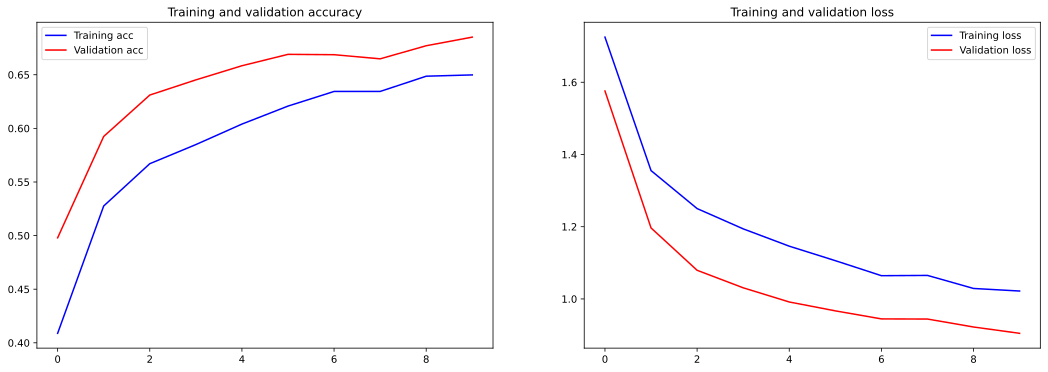

<Figure size 432x288 with 0 Axes>

In [18]:
# график обучения при полностью замороженной base_model
show_learn_graf(history)

# **Fine Tune: Step 1**



In [19]:
print ("Количество слоев в базовой  модели:", len(base_model.layers))

Количество слоев в базовой  модели: 132


In [20]:
# вот тут собственно размораживаем слои
base_model.trainable = True

fine_tune_at = 65

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


print("обучаемых слоев:", len(base_model.trainable_variables))

обучаемых слоев: 79


In [21]:
# добавим чек-поинты
checkpoint = ModelCheckpoint('best_model_step1.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [22]:
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
IMG_SIZE             = (240, 240) # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (180, 180, IMG_CHANNELS)

In [23]:
# learning rate будем уменьшать по мере разморозки сети
model.compile(loss="categorical_crossentropy", 
                optimizer=optimizers.Adamax(learning_rate=LR/10), 
                metrics=["accuracy"])

In [24]:
# опять обучаем на частично размороженной сети (разморожено 79 слоев )

%%time
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator, 
        validation_steps = len(val_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
195/195 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.6670
Epoch 00001: val_accuracy improved from -inf to 0.69251, saving model to best_model_step1.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


195/195 [==============================] - 246s 1s/step - loss: 0.9852 - accuracy: 0.6670 - val_loss: 0.8944 - val_accuracy: 0.6925
Epoch 2/8
195/195 [==============================] - ETA: 0s - loss: 0.9772 - accuracy: 0.6686
Epoch 00002: val_accuracy did not improve from 0.69251
195/195 [==============================] - 226s 1s/step - loss: 0.9772 - accuracy: 0.6686 - val_loss: 0.8924 - val_accuracy: 0.6906
Epoch 3/8
195/195 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.6637
Epoch 00003: val_accuracy improved from 0.69251 to 0.69347, saving model to best_model_step1.hdf5
195/195 [==============================] - 223s 1s/step - loss: 0.9787 - accuracy: 0.6637 - val_loss: 0.8895 - val_accuracy: 0.6935
Epoch 4/8
195/195 [==============================] - ETA: 0s - loss: 0.9665 - accuracy: 0.6696
Epoch 00004: val_accuracy improved from 0.69347 to 0.69379, saving model to best_model_step1.hdf5
195/195 [==============================] - 223s 1s/step - loss: 0.96

In [39]:
# загружаем лучшую модель
model = load_model('best_model_step1.hdf5') #загрузка

In [26]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 34s 672ms/step - loss: 0.9047 - accuracy: 0.6851
Accuracy: 68.51%


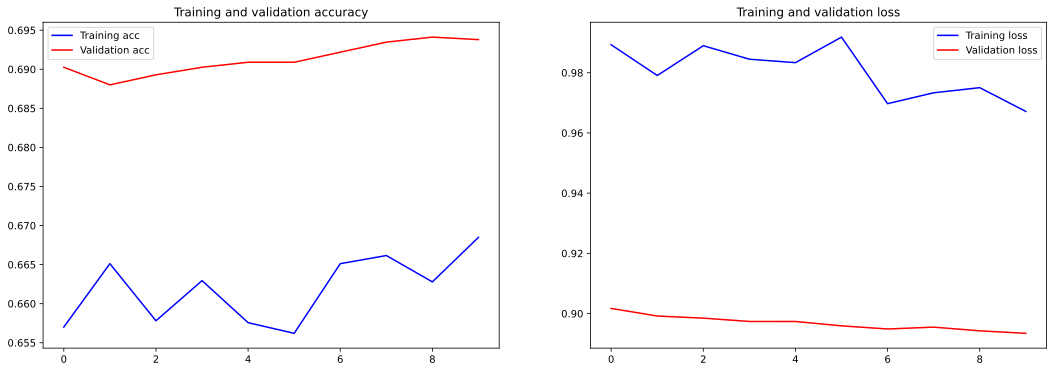

<Figure size 432x288 with 0 Axes>

In [40]:
# график обучения при размороженных 79 слоях
show_learn_graf(history)

# **Fine Tune: Step 2**

In [41]:
print("количество размороженных слоев base_model:", len(base_model.trainable_variables))

количество размороженных слоев base_model: 154


In [42]:
# вот тут собственно размораживаем слои

fine_tune_layers = 30

for layer in base_model.layers[:fine_tune_layers]:
  layer.trainable = True

len(base_model.trainable_variables)

154

In [43]:
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
IMG_SIZE             = (240, 240) # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (320, 320, IMG_CHANNELS)

In [44]:

model.compile(loss="categorical_crossentropy", 
                optimizer=optimizers.Adamax(learning_rate=LR/10), 
                metrics=["accuracy"])

In [ ]:
# опять обучаем

%%time
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator, 
        validation_steps = len(val_generator),
        epochs = 8,
        callbacks = callbacks_list
)

In [ ]:
# загружаем лучшую модель
model = load_model('best_model.hdf5')

In [ ]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 19s 374ms/step - loss: 0.4561 - accuracy: 0.8594
Accuracy: 85.94%


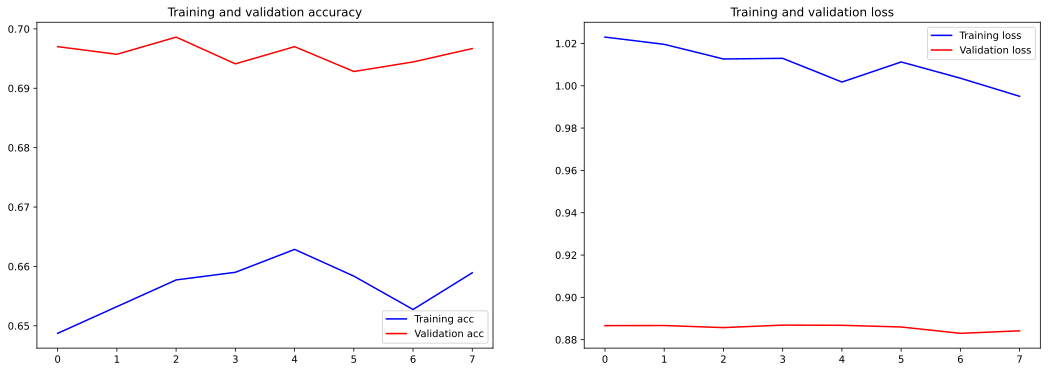

<Figure size 432x288 with 0 Axes>

In [ ]:
# график обучения при размороженных 126 слоях
show_learn_graf(history)

# Fine Tune: Step 3

In [30]:
# пока застряю на точности не более 85%. Поробуем с этого шага изменить размер картинки и аугментацию

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 0.00001
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%
CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = (240, 240) # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (400, 400, IMG_CHANNELS)
RANDOM_SEED          = 0

In [31]:
# тут применим стандартный аугментатор c миниамльными аугментациями

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    horizontal_flip=True,
    zoom_range = [0.5, 1.2],
    fill_mode = "nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

sub_datagen = ImageDataGenerator(
    rescale=1./255
)

In [32]:
print("количество размороженных слоев base_model:", len(base_model.trainable_variables))

количество размороженных слоев base_model: 111


In [33]:
# разморажтиваем все слои

base_model.trainable = True
print("количество обучаемых слоев:", len(base_model.trainable_variables))

количество обучаемых слоев: 154


In [34]:
model.compile(loss="categorical_crossentropy", 
                optimizer=optimizers.Adamax(learning_rate=LR), 
                metrics=["accuracy"])

In [36]:
# последнее обучение, все слои разморожены
%%time
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator, 
        validation_steps = len(val_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.9893 - accuracy: 0.6570
Epoch 00001: val_accuracy did not improve from 0.69765
195/195 [==============================] - 221s 1s/step - loss: 0.9893 - accuracy: 0.6570 - val_loss: 0.9017 - val_accuracy: 0.6903
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.9791 - accuracy: 0.6651
Epoch 00002: val_accuracy did not improve from 0.69765
195/195 [==============================] - 227s 1s/step - loss: 0.9791 - accuracy: 0.6651 - val_loss: 0.8992 - val_accuracy: 0.6880
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.9890 - accuracy: 0.6578
Epoch 00003: val_accuracy did not improve from 0.69765
195/195 [==============================] - 222s 1s/step - loss: 0.9890 - accuracy: 0.6578 - val_loss: 0.8985 - val_accuracy: 0.6893
Epoch 4/10
195/195 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.6629
Epoch 00004: val_accuracy did not improve from 0.69765


In [ ]:
# загружаем лучшую модель
model = load_model('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

49/49 [==============================] - 19s 377ms/step - loss: 0.4447 - accuracy: 0.8639
Accuracy: 86.39%


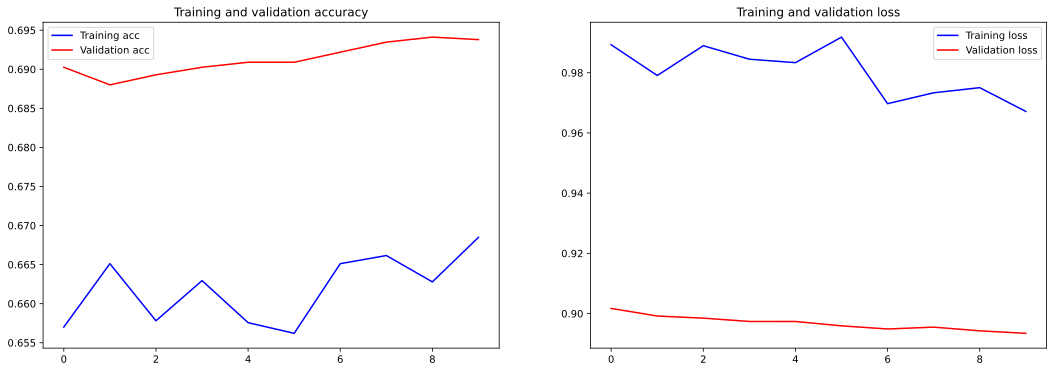

<Figure size 432x288 with 0 Axes>

In [37]:
# график обучения при всех размороженных слоях
show_learn_graf(history)

# Подготовим submission с использованием TTA


In [ ]:
# будем использовать albumantation для submission

sub_datagen  = ImageDataAugmentor(
        rescale=1./255,
        augment = My_augments  )

show_first_images(sub_generator, labels=False)
sub_generator.reset()
show_first_images(sub_generator, labels=False)

In [ ]:
# сделаем 5 предсказаний
predictions = []
for j in range(5):
  predictions.append(model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

In [ ]:
# окончательное предсказание
final_predictions = predictions.mean(axis=0).argmax(axis=-1)

pd.DataFrame(final_predictions).to_csv('submission.csv', index=False)

In [ ]:
test_predict = model.predict(val_generator, verbose=1)
pd.DataFrame(final_predictions).to_csv('test_predict.csv', index=False)

In [ ]:
# загружаем submission
from google.colab import files
files.download('submission.csv')
files.download('test_predict.csv')

# Очистка колаба

Так вы можете освободить ресурсы колаба

In [ ]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )

# New Section